# <center> Finetuned RoBERTa Emotion Classifier (94% Accuracy)</center>
## **<center>Emotion Classifier on Twitter messages with six fundamental emotions: anger, fear, joy, love, sadness, and surprise.</center>**
Author: Shiven Taneja

Date: November 2023 

[GitHub](https://github.com/shiven-taneja/) 

[LinkedIn](https://www.linkedin.com/in/shiven-taneja/)


# 1. Overview
I have been completing the [Practical Deep Learning For Coders](https://course.fast.ai/) course by [Fast.AI](https://fast.ai). In the fourth lesson, we started diving into Natural Language Processing (NLP). I wanted to expand on this knowledge and take it one step further and do multi-label classification while also getting familiar with [HuggingFace](https://huggingface.co/) .

# 2. Setting up the enviornment + Data Manipulation
## 2.1 Data import 

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
OUTPUT_DIR = './'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

/kaggle/input/emotions/text.csv


In [2]:
path = Path('../input/emotions')

In [3]:
!ls {path}

text.csv


## 2.2 Understanding the Data 

In [4]:
df = pd.read_csv(path/'text.csv')

In [5]:
df.head()

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4


In [6]:
df.describe(include='object')

,text
count,416809
unique,393822
top,i feel more adventurous willing to take risks
freq,16


In [7]:
mapping = {0 : "sadness",
           1 : "joy",
           2 : "love",
           3 : "anger",
           4 : "fear",
           5 : "surprise"
}

df["emotion"] =  df["label"].map(mapping)

In [8]:
df.head()

,Unnamed: 0,text,label,emotion
0,0,i just feel really helpless and heavy hearted,4,fear
1,1,ive enjoyed being able to slouch about relax a...,0,sadness
2,2,i gave up my internship with the dmrg and am f...,4,fear
3,3,i dont know i feel so lost,0,sadness
4,4,i am a kindergarten teacher and i am thoroughl...,4,fear


Here I create a visualization of the spread of data across the various emotions

<Axes: xlabel='emotion', ylabel='count'>

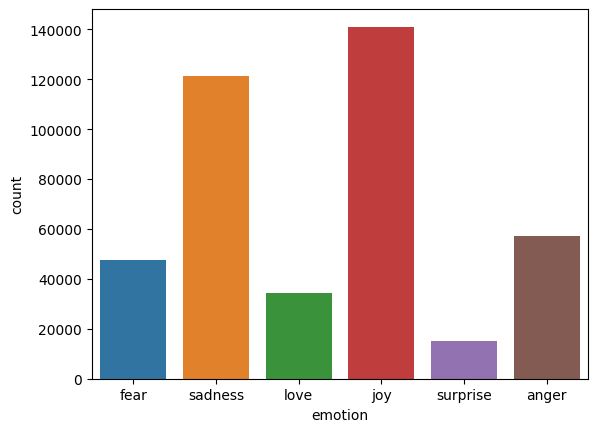

In [9]:
sns.countplot(df, x='emotion')

## 2.3 Creating the Evaluation Dataset

In [10]:
np.random.seed(42)
df = df.sample(frac=1).reset_index(drop=True)

eval_ratio = 0.15 
total = df.shape[0]
eval_end = int(total * eval_ratio)

eval_df = df[:eval_end]

df = df[eval_end:]
print(total, len(eval_df), len(df), len(eval_df) + len(df))

416809 62521 354288 416809


# 3. Setting up the Model and Helper Functions


In [11]:
model_nm = "FacebookAI/roberta-base"

In [12]:
 ! pip install -q datasets

In [13]:
from datasets import Dataset, DatasetDict

ds = Dataset.from_pandas(df)

## 3.1 Tokenizer
Here I am importing the Roberta Base tokenizer and then tokenizing my dataset

In [14]:
from transformers import TrainingArguments,Trainer,AutoModelForSequenceClassification,AutoTokenizer
tokz = AutoTokenizer.from_pretrained(model_nm)

2024-04-10 13:52:00.101563: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-10 13:52:00.101658: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-10 13:52:00.237912: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [15]:
def tok_func(x): return tokz(x["text"])

In [16]:
tok_ds = ds.map(tok_func, batched=True)

  0%|          | 0/355 [00:00<?, ?ba/s]

In [17]:
eval_ds = Dataset.from_pandas(eval_df).map(tok_func, batched=True)

  0%|          | 0/63 [00:00<?, ?ba/s]

In [18]:
tok_ds[0]

{'Unnamed: 0': 89246,
 'text': 'i feel a little inadequate to advise them as i have no knowledge of the timing of their local nectar flows',
 'label': 0,
 'emotion': 'sadness',
 'input_ids': [0,
  118,
  619,
  10,
  410,
  15650,
  7,
  12922,
  106,
  25,
  939,
  33,
  117,
  2655,
  9,
  5,
  5801,
  9,
  49,
  400,
  295,
  39459,
  7964,
  2],
 'attention_mask': [1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1,
  1]}

## 3.2 Train-Test Split

In [19]:
dds = tok_ds.train_test_split(0.25, seed=42)
dds

DatasetDict({
    train: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'emotion', 'input_ids', 'attention_mask'],
        num_rows: 265716
    })
    test: Dataset({
        features: ['Unnamed: 0', 'text', 'label', 'emotion', 'input_ids', 'attention_mask'],
        num_rows: 88572
    })
})

## 3.3 Args
Here I am importing the tranformers library and then creating the arguments to be passed into the transormer

In [20]:
from transformers import TrainingArguments,Trainer

In [21]:
bs = 96
epochs = 4

In [22]:
lr = 8e-5

In [23]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
    evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
    num_train_epochs=epochs, weight_decay=0.01, report_to='none', save_total_limit = 3)

## 3.4 Metrics
Below I am creating the metrics to evaluate my dataset. I am just using accuracy. Heavily inspired by [Jesus Leal](https://jesusleal.io/2021/04/21/Longformer-multilabel-classification/).

In [24]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from transformers import EvalPrediction
import torch
    
def multi_label_metrics(predictions, labels):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    y_pred = np.argmax(probs, axis=1)
    # finally, compute metrics
    y_true = labels
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'accuracy': accuracy}
    return metrics

def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, 
            tuple) else p.predictions
    result = multi_label_metrics(
        predictions=preds, 
        labels=p[1])
    return result

## 3.4 Setting up the Model + Trainer

In [25]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=6)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                  tokenizer=tokz, compute_metrics=compute_metrics)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## 3.5 Training the Model 

In [27]:
trainer.train();

Epoch,Training Loss,Validation Loss,Accuracy
1,0.121500,0.105603,0.939089
2,0.094200,0.094732,0.942183
3,0.088500,0.089897,0.943018
4,0.083400,0.088305,0.943549


In [ ]:
trainer.save_model("/kaggle/working/BERT_Emotions")

# 4 Testing the model 
Finally I am testing the model on the Eval Dataset which we removed from the training/test set. This ensures that we are evaluating the model on data it has never seen before. 

The model is able to acheive **over 94% accuracy**


In [ ]:
preds = trainer.predict(eval_ds).predictions.astype(float)
print(multi_label_metrics(preds, eval_ds['label']))

{'accuracy': 0.9421314438348715}
